# A Computational Model of Integration of Landmarks & Motion in the Insect Central Complex

## 1. Testing AVDU and Landmark features

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from InputProcessor import process_input
import h5py

Text(0.5, 1.0, 'Positional response for different neurons at 800deg/s')

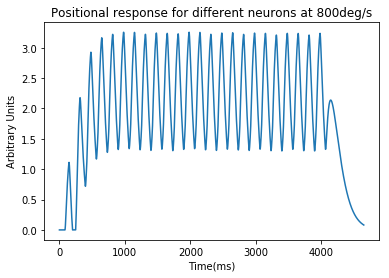

In [5]:
t, pos_out, avdu_out = process_input(800)
plt.plot(avdu_out[1,:])
plt.xlabel("Time(ms)")
plt.ylabel("Arbitrary Units")
plt.title("Positional response for different neurons at 800deg/s")

Text(0.5, 1.0, 'Positional response for different neurons at 800deg/s')

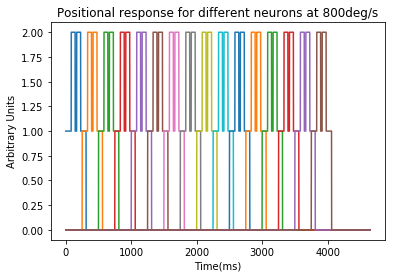

In [6]:
# Plotting outputs of broad receptive fields for landmark detection
for i in range(16):
    plt.plot(pos_out[i,:])
plt.xlabel("Time(ms)")
plt.ylabel("Arbitrary Units")
plt.title("Positional response for different neurons at 800deg/s")

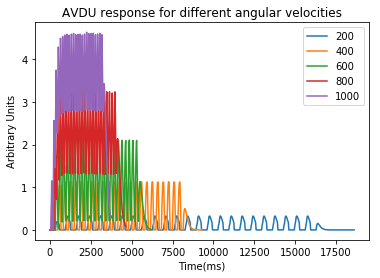

In [7]:
for i in range(5):
    t,pos_out, avdu_out = process_input((i+1)*200)
    plt.plot(avdu_out[1,:])
plt.xlabel("Time(ms)")
plt.ylabel("Arbitrary Units")
plt.title("AVDU response for different angular velocities")
plt.legend(["200","400","600","800","1000"])

Text(0.5, 1.0, 'AVDU Response vs angular velocity')

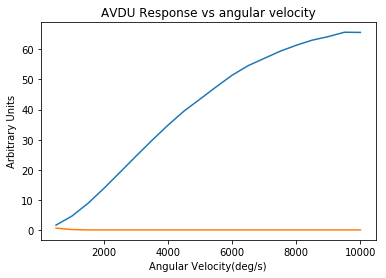

In [4]:
# Plotting response of AVDUs in preferred and non-preferred direction
xx = np.zeros(20)
yy = np.zeros(20)
x=[]
for i in range(20) :
    t,pos_out, avdu_out = process_input((i+1)*500)
    xx[i] = np.max(avdu_out[1,])
    yy[i] = np.max(avdu_out[0,])
    x.append((i+1)*500)

plt.plot(x,xx)
plt.plot(x,yy)
plt.xlabel("Angular Velocity(deg/s)")
plt.ylabel("Arbitrary Units")
plt.title("AVDU Response vs angular velocity")

In [41]:
def create_input_file(file_name, dt=1e-4, angular_velocity = 500):
    """
    Create input stimulus for sensory neurons in artificial LPU.
    Creates an HDF5 file containing input signals for the specified number of
    neurons. The signals consist of a rectangular pulse of specified duration
    and magnitude.
    Parameters
    ----------
    file_name : str
        Name of output HDF5 file.
    dt : float
        Time resolution of generated signal.
    """
    t, pos_out, avdu_out = process_input(800)
    inp = np.transpose(np.concatenate((avdu_out,pos_out)))

    
    N_driver = 2
    N_ring = 16
    
    uids = ["driver_" + str(i) for i in range(N_driver)]
    uids.extend(["pos_" + str(i) for i in range(N_ring)])
    uids = np.array(uids, dtype = 'S')


    with h5py.File(file_name, 'w') as f:
        f.create_dataset('I/uids', data=uids)
        f.create_dataset('I/data', (len(t),N_driver+N_ring),
                         dtype=np.float64,
                         data=inp)
        f.close()
        
create_input_file("input.h5")

## 2. Visualizing the CX outputs

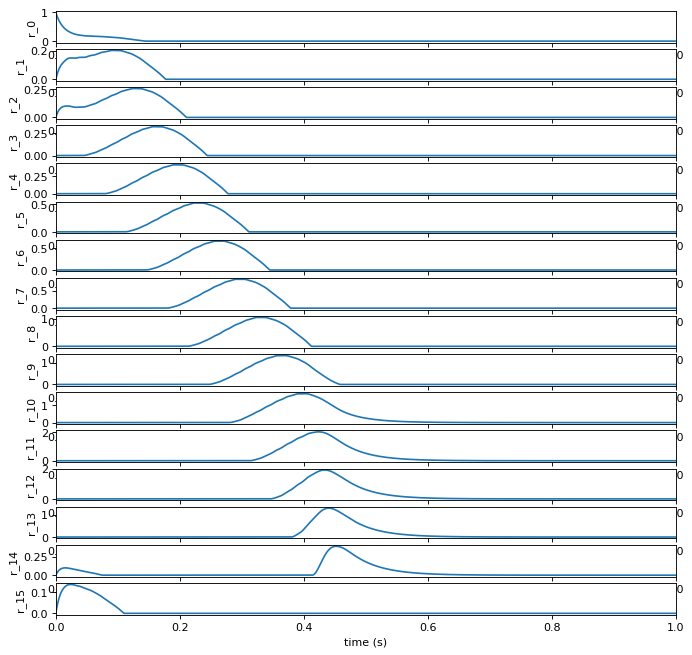

In [5]:
# Motion Detection Test: angular velocity = 800
# Make pos weight 0, initialise ring_0 with initV=1 in RingAttractorNetwork.py
import h5py
import numpy as np
import matplotlib.pyplot as plt

f = h5py.File('output.h5', 'r')
dt = 1e-4
dur = 1
t = np.arange(0,dur,dt)
        
plt.figure(num=None, figsize=(10,10), dpi=80)
for i in range(16):
    var = 'V'
    node = bytes('ring_'+str(i), encoding='utf-8')
    idx = [a for a in f[var]['uids']].index(node)
    plt.subplot(16,1,i+1)
    plt.plot(t,np.transpose(f[var]['data'])[idx])
    plt.ylabel('r_'+str(i))
    plt.xlim((0,1))
plt.xlabel('time (s)')
plt.savefig('Results/cx_motion.png')

f.close()

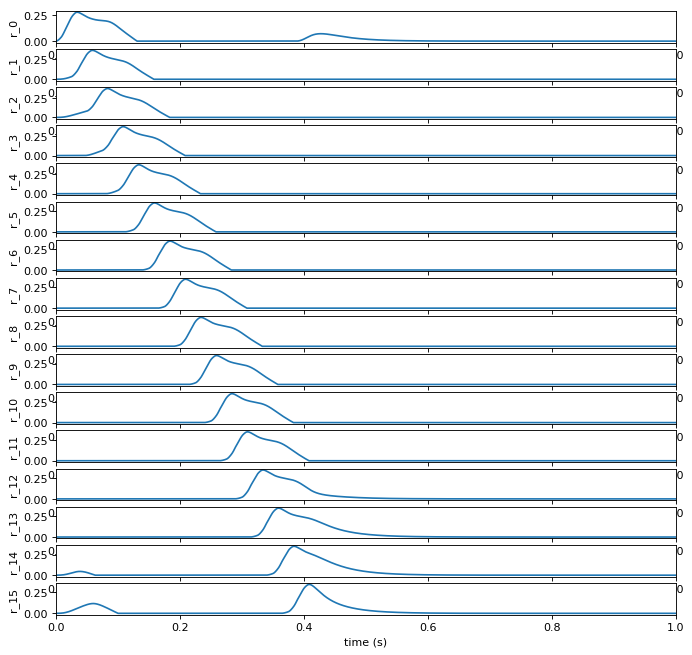

In [58]:
# Landmark Detection Test: angular velocity = 800
# Make rota, rotb weight 0, pos->ring synapse weight 0.1 in RingAttractorNetwork.py
import h5py
import numpy as np
import matplotlib.pyplot as plt

f = h5py.File('output.h5', 'r')
dt = 1e-4
dur = 1
t = np.arange(0,dur,dt)
        
plt.figure(num=None, figsize=(10,10), dpi=80)
for i in range(16):
    var = 'V'
    node = bytes('ring_'+str(i), encoding='utf-8')
    idx = [a for a in f[var]['uids']].index(node)
    plt.subplot(16,1,i+1)
    plt.plot(t,np.transpose(f[var]['data'])[idx])
    plt.ylabel('r_'+str(i))
    plt.xlim((0,1))
plt.xlabel('time (s)')
plt.savefig('Results/cx_landmark.png')

f.close()

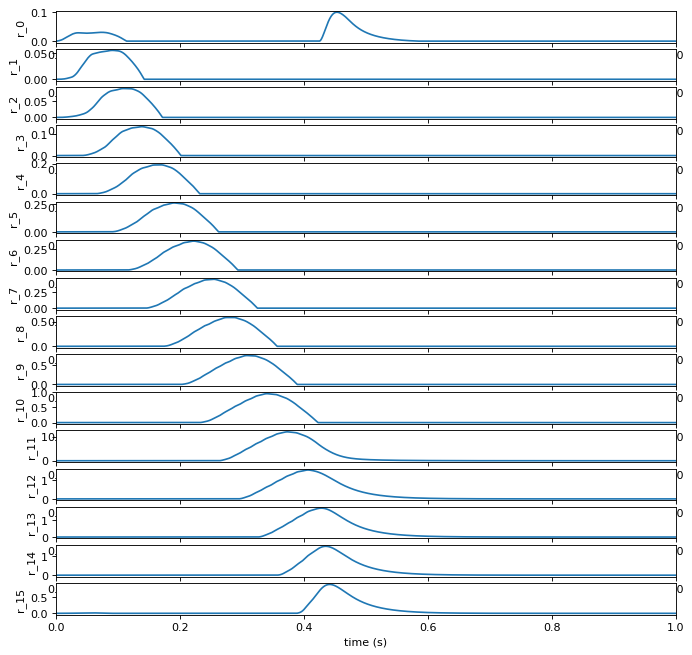

In [61]:
# Integrated Test: angular velocity = 800
# Make pos->ring synapse weight 0.01 in RingAttractorNetwork.py
import h5py
import numpy as np
import matplotlib.pyplot as plt

f = h5py.File('output.h5', 'r')
dt = 1e-4
dur = 1
t = np.arange(0,dur,dt)
        
plt.figure(num=None, figsize=(10,10), dpi=80)
for i in range(16):
    var = 'V'
    node = bytes('ring_'+str(i), encoding='utf-8')
    idx = [a for a in f[var]['uids']].index(node)
    plt.subplot(16,1,i+1)
    plt.plot(t,np.transpose(f[var]['data'])[idx])
    plt.ylabel('r_'+str(i))
    plt.xlim((0,1))
plt.xlabel('time (s)')
plt.savefig('Results/cx_integrated.png')

f.close()

In [6]:
def calculate_azimuth(file,init_angle):
    f = h5py.File(file, 'r')
    var = 'V'
    idx = []
    for i in range(16):
        node = bytes('ring_'+str(i), encoding='utf-8')
        idx.append([a for a in f[var]['uids']].index(node))
        
    data = np.transpose(f[var]['data'][:,idx])
    
    neu_num, t = np.shape(data)
    
    angles = np.arange(0+360/neu_num/2,360,360/neu_num)*np.pi/180
    v_r = np.concatenate(([np.cos(angles)],[np.sin(angles)])).T
    v_init = np.array([np.cos(init_angle*np.pi/180),np.sin(init_angle*np.pi/180)])
    azimuth = np.zeros(t)
    
    for i in range(t):
        v_sum = np.dot(data[:,i],v_r)
        if np.any(v_sum):
            v_sum/= np.linalg.norm(v_sum)
            azimuth[i] = np.arccos(np.dot(v_sum,v_init))*180/np.pi
            if v_sum[1]<0:
                azimuth[i] = 360-azimuth[i]
            
    f.close()
    return azimuth

In [83]:
t_end = (360-360/16)/0.75

t_total = np.arange(0,t_end,0.1)
temp = t_total*0.75
azimuth_true = np.zeros(10000) + temp[-1]
azimuth_true[:len(temp)] = temp

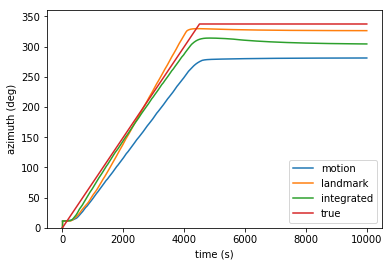

In [86]:
azimuth_motion = calculate_azimuth('Results/output_motion.h5',init_angle=0)
azimuth_landmark = calculate_azimuth('Results/output_landmark.h5',init_angle=0)
azimuth_integrated = calculate_azimuth('Results/output_integrated.h5',init_angle=0)
plt.plot(azimuth_motion, label='motion')
plt.plot(azimuth_landmark, label='landmark')
plt.plot(azimuth_integrated, label='integrated')
plt.plot(azimuth_true, label='true')
plt.legend(loc=4)
plt.xlabel('time (s)')
plt.ylabel('azimuth (deg)')
plt.ylim((0,360))
plt.savefig('Results/azimuth_tracking')